In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# General imports
import os
from pathlib import Path 
import traceback
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix

In [24]:
os.getcwd()

'f:\\School\\TU_DELFT_THESIS\\hyperbolic-tsne'

In [25]:
# HyperbolicTSNE imports
from hyperbolicTSNE import Datasets, load_data
from hyperbolicTSNE import Datasets, SequentialOptimizer, initialization, HyperbolicTSNE
from hyperbolicTSNE.cost_functions_ import HyperbolicKL, GaussianKL
from hyperbolicTSNE.util import find_last_embedding, opt_config, initialize_logger, save_experiment_results, next_experiment_folder_id, GaussianKL_results, HyperbolicKL_results
from hyperbolicTSNE.data_loaders import load_mnist
from hyperbolicTSNE.hd_mat_ import hd_matrix
from hyperbolicTSNE.visualization import plot_poincare

# Initialization

General initialization values

In [ ]:
log_path = "temp/poincare/"  # path for saving embedding snapshots
grad_path = "temp/grad/"     # NOTE: We will manually calculate the gradients
data_home = "datasets"

experiments_folder = "./experiment_results/"
exp_id = next_experiment_folder_id(experiments_folder)

# Experiment settings
seed = 42
correct_grads = [False]                   # NOTE: Recompile with correct flag (GRAD_FIX flag)
exacts = [False]                          # NOTE: Exact computation or BH estimation of gradient
grad_scale_fixes = [False]          # Whether we multiply the gradient by the inverse metric tensor of hyperbolic space or not
                                          # Note that the correct hyperoblic gradient has an inverse metric tensor factor

# Simple experiment with no exaggeration
exaggeration_factor = 12
ex_iterations = 10
main_iterations = 0

# Cost functions
cfs = [HyperbolicKL]

# Other params
size_tol = 0.999
max_dist_H = 0
max_dist = 0    

Initialization values for the non custom datasets

In [27]:
datasets = [Datasets.MNIST]
num_points = [0.1]
perplexities = [25]
pca_components = [50]                              # Whether to use pca initialization of high dim. data or not

In [28]:
from itertools import product


# NOTE: Exerpimental details for unfixed datasets etc..
# experiment_details = list(product(datasets, num_points, perplexities, pca_components, cfs, correct_grads, exacts))




# NOTE: Below, experimental setup details for when we have a fixed dataset and dataset parameters 
# NOTE: But have different cost functions and cost function settings
experiment_details_2 = list(product(cfs, correct_grads, exacts, grad_scale_fixes))

for experiment in experiment_details_2:
    print(experiment)

(<class 'hyperbolicTSNE.cost_functions_.HyperbolicKL'>, True, False, True)


In [29]:
dataset = datasets[0]
num_p = num_points[0]
perp = perplexities[0]
pca = pca_components[0]


# (0) Load data
dataX, dataLabels, D, V, *rest = load_data(
    dataset, 
    data_home=data_home, 
    pca_components=pca,
    random_state=seed, 
    to_return="X_labels_D_V",
    hd_params={"perplexity": perp}, 
    sample=num_p, 
    knn_method="hnswlib"  # we use an approximation of high-dimensional neighbors to speed up computations
)


# (1) Compute initial embedding in Poincare disk (PCA embedding)
X_embedded = initialization(
    n_samples=dataX.shape[0], 
    n_components=2,
    X=dataX,
    random_state=seed,
    method="random",
    init_scale=1e-4         # spread out initializations more
) 

print("Data shape: ", X_embedded.shape)

Data shape:  (7000, 2)


Code for running a bunch of experiments at the same time (types of experiments defined above)

[Experiment: 105] 
 dataset: Datasets.MNIST, num_p: 0.1, perp: 25,pca: 50, correct_grad: False, exact: False, scale_fix: False

learning rate: 0.5833333333333334
Please note that `empty_sequence` uses the KL divergence with Barnes-Hut approximation (angle=0.5) by default.
config: {'cf': <class 'hyperbolicTSNE.cost_functions_.HyperbolicKL'>, 'learning_rate_ex': 0.5833333333333334, 'learning_rate_main': 0.5833333333333334, 'exaggeration': 12, 'exaggeration_its': 10, 'gradientDescent_its': 0, 'vanilla': True, 'momentum_ex': 0.5, 'momentum': 0.2, 'exact': False, 'area_split': False, 'n_iter_check': 2000, 'size_tol': 0.999, 'grad_scale_fix': False, 'grad_fix': False, 'n_iter_without_progress': 2000, 'min_grad_norm': 1e-10}
[HyperbolicTSNE] Received iterable as input. It should have len=2 and contain (D=None, V=None)
[hd_mat] Warning: There is nothing to do with given parameters. Returning given D and V
[gradient_descent] Warning: because of logging, the cf will be computed at every iteratio

Gradient Descent error: 95.46813 grad_norm: 8.43226e-01: 100%|██████████| 10/10 [00:00<00:00, 13.49it/s]


[gradient_descent] Warning: because of logging, the cf will be computed at every iteration


Gradient Descent: 0it [00:00, ?it/s]


Animation being saved to: ./experiment_results/experiment_105//emb_anim.gif


Animating:   0%|          | 0/1 [00:00<?, ?it/s]/Users/haoranxia/Thesis-Delft/hyperbolic-tsne/hyperbolicTSNE/visualization.py:354: UserWarning: You passed in an explicit save_count=50 which is being ignored in favor of frames=1.
  anim = FuncAnimation(fig, update, frames=len(scatter_data), interval=50, blit=True, save_count=50)
MovieWriter ffmpeg unavailable; using Pillow instead.
Animating: : 4it [00:00, 27.54it/s]             


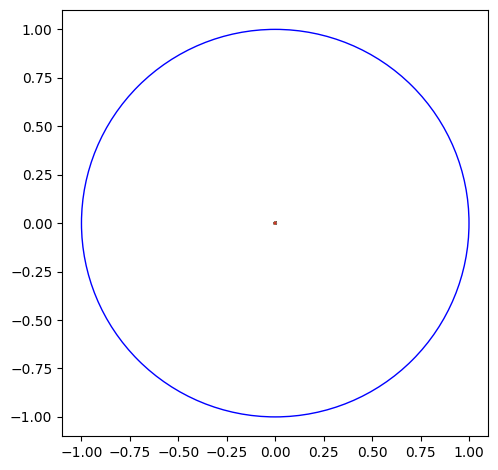

In [30]:
# Run experiments
# for (dataset, num_p, perp, pca, cf, correct_grad, exact) in experiment_details:
for (cf, correct_grad, exact, grad_scale_fix) in experiment_details_2:
    print(f"\n[Experiment: {exp_id}] \n dataset: {dataset}, num_p: {num_p}, perp: {perp},pca: {pca}, correct_grad: {correct_grad}, exact: {exact}, scale_fix: {grad_scale_fix}\n")
    
    # NOTE: Uncomment if we decide to go with multiple datasets etc..
    # # (0) Load data
    # dataX, dataLabels, D, V, *rest = load_data(
    #     dataset, 
    #     data_home=data_home, 
    #     pca_components=pca,
    #     random_state=seed, 
    #     to_return="X_labels_D_V",
    #     hd_params={"perplexity": perp}, 
    #     sample=num_p, 
    #     knn_method="hnswlib"  # we use an approximation of high-dimensional neighbors to speed up computations
    # )

 
    # # (1) Compute initial embedding in Poincare disk (PCA embedding)
    X_embedded = initialization(
        n_samples=dataX.shape[0], 
        n_components=2,
        X=dataX,
        random_state=seed,
        method="random",
        init_scale=1e-4         # spread out initializations more
    ) 

    # Set learning rates
    if cf == GaussianKL:        
        hyp_var = 0.2
        learning_rate = dataX.shape[0] / (exaggeration_factor * 10) * hyp_var

    else:
        learning_rate = dataX.shape[0] / (exaggeration_factor * 1000)

    print(f"learning rate: {learning_rate}")

    # Initialize configs
    opt_conf = opt_config(cf, learning_rate, exaggeration_factor, ex_iterations, main_iterations, exact=exact, vanilla=True, grad_scale_fix=grad_scale_fix, grad_fix=correct_grad, max_no_progress=int(main_iterations/2))
    opt_params = SequentialOptimizer.sequence_poincare(**opt_conf) 
    log_path_cf = log_path + f"cf_{cf.class_str()}/correct_grad_{correct_grad}/"
    grad_path_grad = grad_path + f"cf_{cf.class_str()}/correct_grad_{correct_grad}/"


    # (3) Update config params using computed variance  
    opt_params, opt_conf = initialize_logger(opt_params, opt_conf, log_path_cf, grad_path_grad)
    opt_params["cf_params"].update({"grad_fix" : correct_grad})     # So the cost function knows which gradient to use
    if cf == GaussianKL: opt_params["cf_params"].update({"var" : hyp_var})     # GaussianKL variance for q_ij


    # (4) Set up t-SNE object and run
    htsne = HyperbolicTSNE(
        init=X_embedded, 
        n_components=2, 
        metric="precomputed",
        verbose=1, 
        opt_method=SequentialOptimizer,         # the optimizater we use
        opt_params=opt_params              # the parameters for the optimizers
    )

    # Compute embedding:
    try:
        hyperbolicEmbedding = htsne.fit_transform((D, V))
        
    except ValueError:
        hyperbolicEmbedding = find_last_embedding(log_path)
        traceback.print_exc()


    emb_fig = plot_poincare(hyperbolicEmbedding, dataLabels, dataLabels)

    # (6) Store experiment results
    # folder to save results to
    save_folder = f"./experiment_results/experiment_{exp_id}/"   
    exp_id += 1    

    # dictionary containing relevant details of this experiment
    optim_procedure = "Vanilla SGD"
    description = "HyperbolicKL MNIST, with more data, more iterations, wrong gradient, to see if it converges to correct gradient embeddings eventually"

    if cf == GaussianKL:
        exp_data = GaussianKL_results(dataset.name, htsne, ex_iterations, perp, num_p, pca,
                       main_iterations, cf, hyp_var, size_tol, max_dist_H, max_dist, correct_grad,
                       grad_scale_fix, exact, exaggeration_factor, optim_procedure, description)
        
    elif cf == HyperbolicKL:
        exp_data = HyperbolicKL_results(dataset.name, htsne, ex_iterations, perp, num_p, pca,
                       main_iterations, cf, correct_grad, grad_scale_fix, exact, 
                       exaggeration_factor, optim_procedure, description)

    animation_step = 25
    save_experiment_results(save_folder, None, emb_fig, opt_params, dataLabels, exp_data, hyperbolicEmbedding, htsne=htsne, step=animation_step)

### Computing Hyperbolic Variance

First we compute how many Euclidean variances wide the maximum distance between 2 datapoints is:
$$ c = \frac{D_{max}}{\sigma^2_E} $$

By setting the Hyperbolic variance to (below) we gain a value for the Hyperbolic variance that hopefully causes the Hyperbolic embeddings to stay reasonably within the visualizable part of the Poincare Disk.
$$ \sigma^2_D = \frac{d^H(-0.99, 0.99)}{c}$$

[TODO: Expand on elaboration]
This is because I suspect that by relating the variance (like in above), the embedding process will cause embeddings to not spread out too much. Since when we are matching the probability distributions, the probabilities will fall off quick as we get multiple variances away. By relating the variance to the maximum distance we want out of our embedding, and at the same time having a $$ c $$ that encodes the high dimensional relatonship between embedding distance size and variance, 


Store experiment results and data into a dedicated folde

# Gradient Analysis


### Numerical analysis of gradients

Investigate the probability distributions of high/low dim. respectively between the 2 gradients
Investigate ratio of gradients between correct/wrong gradient

In [ ]:
# Hyperbolic distance between y1, y2
def hyp_dist(y1, y2):
    diff = y1 - y2
    num = diff.dot(diff)                         # numerator
    denum = (1 - y1.dot(y1)) * (1 - y2.dot(y2))  # denumerator
    dist = np.arccosh(1 + 2 * (num / denum))

    return dist


# Compute the probability distribution associated with our embedding.
# Low dimensional affinities, computed from embeddings 
def compute_affinities(embedding_data):
    Q = np.zeros((embedding_data.shape[0], embedding_data.shape[0]))
    for i in range(Q.shape[0]):
        for j in range(i + 1, Q.shape[1]):
            dist = hyp_dist(embedding_data[i], embedding_data[j])       # hyp. distance
            dist = 1. / (1 + dist**2)                                   # t-distrib. "distance"
            Q[i][j] = dist
            Q[j][i] = dist

    # Normalize distances to probabilities
    # return Q / Q.sum()
    return Q / Q.sum()

In [ ]:
# Recomputing probability matrices
P = V.toarray()                         # high dim. affinity
Q = compute_affinities(data["Emb"])     # low dim. affinity

print(P[0])
print()
print(Q[0])

print(P - Q)

# Analysis of behaviour at beginning (early iterations)

1. hyp. distances are small $d^{H}_{ij}$ approaches 0 (since $cosh^{-1} goes to 0), since its argument goes to 1.

2. This means t-distrib. probability goes to 1, $(1 + (d^{H}_{ij})^2)^{-1}$ goes to 1.
So once normalized, all probabilities $q^{H}_{ij}$ are almost the same for all $ij$, so we basically have an uniform distribution for $q^{H}_{ij}$

3. Why are the wrong gradients so much bigger?

Correct Gradient expression:
$$ 4  \sum_{j} (p_{ij} - q^{H}_{ij}) (1 + (d^{H}_{ij})^2)^{-1}  d^{H}_{ij} \frac{d^{H}_{ij}}{y_i}$$

\
Wrong Gradient expresion:
$$ 4  \sum_{j} (p_{ij} - q^{H}_{ij}) (1 + (d^{H}_{ij})^2)^{-1} \frac{d^{H}_{ij}}{y_i}$$

\
Because in early iterations, $ d^{H}_{ij} $ is approximately 0, the correct gradient is very small, until points haved moved sufficiently for this term to increase in value.

Can this possibly replace early exaggeration? Maybe.. 
At the beginning, points are updated in very small amounts. But this applies to both attractive and repulsive forces.

At some points, points are "distant" enough, for $ d^{H}_{ij} $ to not matter much anymore. 

$ d^{H}_{ij} $ goes up a lot (to possibly infinity) for larger distances. This means that forces between distant points get heavily amplified. Is this an issue though? Since very distant forces should be more or less 0?

4. Is the use of the t-distribution justified in hyperbolic space?
Is it making repellant points feel a repellant force for way too far distances?
What do p, q look like for points far away? Is the heavy-tailedness a problem in hyperbolic space?

Despite large distances, $ q^{H}_{ij} $ is never able to reach the "correct" probabilities due to the use of the t-distribution? Since the heavy tails requires too big of distances for things to converge properly. Hence points keep getting pushed out? 

We can try using a regular gaussian distribution for $ q^{H}_{ij} $. Rederive the gradient, and experiment with that.
But do we then need to take the symmetric version into account?